# **Quanvolutional Neural Network**

Quanvolutional Neural Networks (QNNs) are an intriguing extension of classical Convolutional Neural Networks (CNNs) that harness the power of quantum computation.

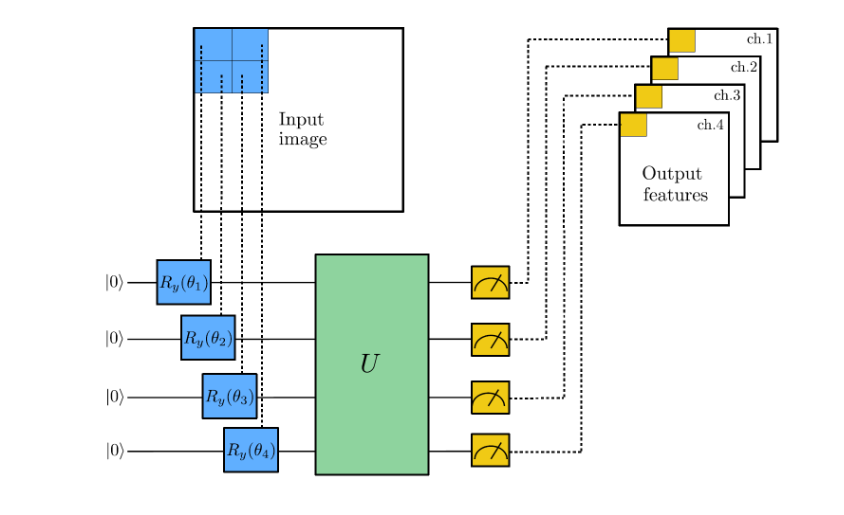  



QNNs introduce a new type of transformational layer called a **quantum convolutional layer** (or quanvolutional layer). These layers locally transform input data using random quantum circuits, akin to how classical CNNs use convolutional filter layers. If these quantum transformations yield meaningful features for classification, QNNs could be practical for near-term quantum computers, as they require small quantum circuits with minimal error correction.

We will give a brief description about Classical Convolution and Quantum Convolution like what these are and how they work

# **Classical Convolution**

One common model in classical machine learning is the convolutional neural network (CNN), which works well for processing pictures. The model is based on the concept of a convolution layer, where a local convolution is used in place of processing the entire input data with a global function.

The CNN uses the precise kernel to process tiny local areas progressively while processing picture inputs. Typically, the output generated for each zone corresponds to distinct channels inside a single output pixel. All of the output pixels are combined to form a new object that appears like a picture, which may then be subjected to several levels of processing.

# **Quantum Convolution**

The concept of extending ideas to the context of quantum variational circuits can also be applied to the process of quantum convolution.

Initially, a small portion of the input image, such as a **2x2 square**, is integrated into a quantum circuit. In this demonstration, this integration is achieved through parametrized rotations applied to qubits that are initialized in the ground state.

Subsequently, a quantum computation, associated with a **unitary U**, is carried out on the system. This unitary may be generated by a **variational quantum circuit**.

Following the quantum computation, the quantum system is measured, resulting in a list of classical expectation values. While the measurement results could be post-processed classically, for the purpose of this demonstration, the raw expectation values are used directly.

Similar to a classical convolution layer, **each expectation value** is linked to a different channel of a single output pixel. By iterating this procedure over different regions, the full input image can be scanned, ultimately producing a multi-channel image as the output.

The quantum convolution can be succeeded by additional quantum layers or classical layers. The key distinction from a classical convolution lies in the fact that a quantum circuit can generate highly complex kernels whose computation could be considered classically intractable, at least in principle.

# **Importing Required Libraries**

In [1]:
!pip install pennylane
# Import Required libraries
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 49.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 42.5 MB/s eta 0:00:00


The necessary libraries are imported in this code cell for the task. TensorFlow is used for machine learning, NumPy is used for numerical operations, Matplotlib is used for graphing, and PennyLane is used for quantum computation jobs.

# **Setting Hyperparameters**

In [2]:
# Set hyperparameters
n_epochs = 10    # Number of optimization epochs (reduced for faster execution)
n_layers = 1     # Number of random layers in the quantum circuit
n_train = 50     # Size of the train dataset
n_test = 30      # Size of the test dataset

# Set random seeds for reproducibility
np.random.seed(0)
tf.random.set_seed(0)

This section configures the model's hyperparameters and random seeds to ensure repeatability. In this case, the number of epochs is lowered to enable faster execution.

# **Loading the MNIST Dataset**

In [3]:
# Load and preprocess the MNIST dataset
mnist_dataset = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist_dataset.load_data()

# Reduce dataset size
train_images = train_images[:n_train]
train_labels = train_labels[:n_train]
test_images = test_images[:n_test]
test_labels = test_labels[:n_test]

# Normalize pixel values to be between 0 and 1
train_images = train_images / 255
test_images = test_images / 255

# Add an extra dimension for convolution channels
train_images = np.array(train_images[..., tf.newaxis], requires_grad=False)
test_images = np.array(test_images[..., tf.newaxis], requires_grad=False)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Here, we first load the MNIST dataset, which is a widely used benchmark dataset for image classification. We next preprocess the dataset by adding an additional dimension for convolution channels, lowering its size for quicker execution, and normalizing pixel values.

# **A Quantum Circuit to Use**

To build the circuit, we follow the plan presented in the top figure and described in the Quantum Convolution part. By setting up a PennyLane **default.qubit device**, we may mimic a four-qubit system. The quantum circuit represented by the connected **qnode** is composed of the following:
* A random circuit with n layers;
* A final evaluation in the computational basis that approximates four expectation values;  
* Local Ry rotations contained in an embedding layer (angles scaled by π).

In [5]:
# Define the quantum device and circuit
dev = qml.device("default.qubit", wires=4)        # Initialize a quantum device with 4 qubits
rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, 4))     # Random parameters for the quantum circuit

@qml.qnode(dev)
def circuit(phi):
    """Quantum circuit for convolution.

    Args:
        phi (array[float]): Input data to be encoded into the circuit.

    Returns:
        list[float]: Expectation values of PauliZ measurements on each qubit.
    """
    # Encode input data into the circuit using Ry rotations
    for j in range(4):
        qml.RY(np.pi * phi[j], wires=j)

    # Apply a random quantum circuit (layer)
    RandomLayers(rand_params, wires=list(range(4)))

    # Measure the expectation values of PauliZ on each qubit
    return [qml.expval(qml.PauliZ(j)) for j in range(4)]

# **Performing Quantum Convolution**

In [6]:
def quanv(image):
    """Performs quantum convolution on an image.

    Args:
        image (array[float]): Input image.

    Returns:
        array[float]: Convolved output image.
    """
    out = np.zeros((14, 14, 4))       # Initialize output image

    # Loop over 2x2 squares in the input image
    for j in range(0, 28, 2):
        for k in range(0, 28, 2):

            # Extract a 2x2 square from the image
            phi = [
                image[j, k, 0],
                image[j, k + 1, 0],
                image[j + 1, k, 0],
                image[j + 1, k + 1, 0]
            ]
            # Process the square with the quantum circuit
            q_results = circuit(phi)
            # Assign the results to the corresponding output pixel
            for c in range(4):
                out[j // 2, k// 2, c] = q_results[c]
    return out

The **quanv** function defines the convolution scheme:

1.  the image is divided into squares of $2 \times 2$ pixels;
2.  each square is processed by the quantum circuit;
3.  the $4$ expectation values are mapped into $4$ different channels of
    a single output pixel.

# **Quantum Preprocessing of Images**

The training and test pictures are preprocessed in this cell using the quantum convolution function **quanv** to get them ready for additional processing. In this phase, quantum characteristics are successfully embedded into the visual data.

In [7]:
# Preprocess the training and test images using quantum convolution
q_train_images = []
print("Quantum pre-processing of train images:")
for idx, img in enumerate(train_images):
    print("{}/{}        ".format(idx + 1, n_train),flush=True)
    q_train_images.append(quanv(img))
q_train_images = np.asarray(q_train_images)

q_test_images = []
print("\nQuantum pre-processing of test images:")
for idx, img in enumerate(test_images):
    print("{}/{}        ".format(idx + 1, n_test), flush=True)
    q_test_images.append(quanv(img))
q_test_images = np.asarray(q_test_images)

Quantum pre-processing of train images:
1/50        
2/50        
3/50        
4/50        
5/50        
6/50        
7/50        
8/50        
9/50        
10/50        
11/50        
12/50        
13/50        
14/50        
15/50        
16/50        
17/50        
18/50        
19/50        
20/50        
21/50        
22/50        
23/50        
24/50        
25/50        
26/50        
27/50        
28/50        
29/50        
30/50        
31/50        
32/50        
33/50        
34/50        
35/50        
36/50        
37/50        
38/50        
39/50        
40/50        
41/50        
42/50        
43/50        
44/50        
45/50        
46/50        
47/50        
48/50        
49/50        
50/50        

Quantum pre-processing of test images:
1/30        
2/30        
3/30        
4/30        
5/30        
6/30        
7/30        
8/30        
9/30        
10/30        
11/30        
12/30        
13/30        
14/30        
15/30        
16/30        
17/30        


# **Visualizing the Outputs**

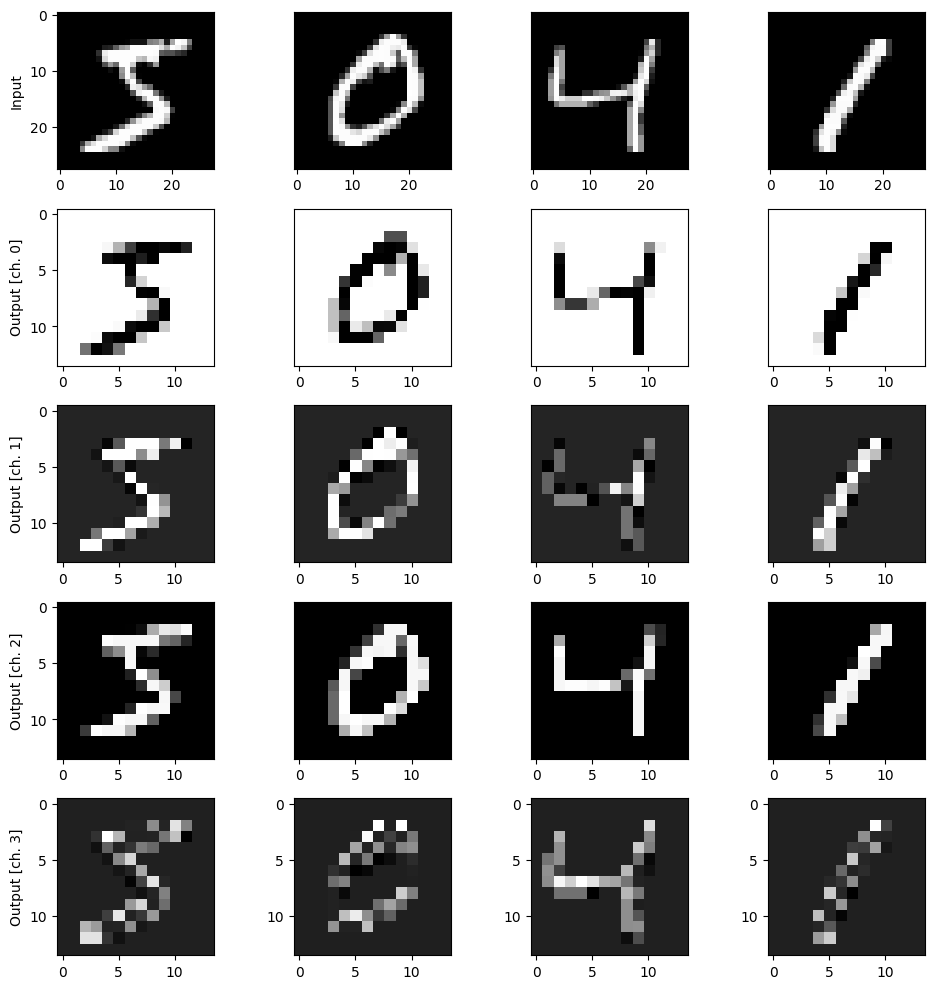

In [8]:
n_samples = 4       # Number of sample images to display
n_channels = 4      # Number of output channels from the quantum convolution
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))  # Create a grid of subplots

for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")  # Label the first row as "Input"
    if k != 0:
        axes[0, k].yaxis.set_visible(False)  # Hide y-axis labels for subsequent input images
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")  # Display the input image in grayscale

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()

This is a helpful illustration that helps explain how the input photos are transformed by the quantum convolution layer. The $4$ output channels produced by the quantum convolution are displayed in grayscale beneath each input image.
It is easy to see that the quantum kernel caused some local distortion and resolution downsampling. Conversely, the convolution layer preserves the image's global form as intended.

# **Hybrid Model**

Here, We employ a very basic model, consisting of a single fully connected layer with ten output nodes and a softmax activation function at the end. A cross-entropy loss function and a stochastic gradient descent optimizer are used in the compilation of the model.

In [9]:
# Define a classical model for classification
def MyModel():
    """Defines a simple Keras model for classification."""
    model = keras.models.Sequential([
        keras.layers.Flatten(),  # Flatten the input data
        keras.layers.Dense(10, activation="softmax")  # Dense layer with softmax activation for classification
    ])
    model.compile(
        optimizer='adam',  # Use the Adam optimizer
        loss="sparse_categorical_crossentropy",  # Use cross-entropy loss for multi-class classification
        metrics=["accuracy"]  # Track accuracy as a metric
    )
    return model

Now, we train the model on the quantum preprocessed training images and evaluates its performance on the quantum preprocessed test images.

In [10]:
# Train the classical model on quantum preprocessed data
q_model = MyModel()  # Initialize the model
q_history = q_model.fit(
    q_train_images,  # Train on quantum preprocessed images
    train_labels,
    validation_data=(q_test_images, test_labels),  # Validate on quantum preprocessed test images
    batch_size=4,
    epochs=n_epochs,
    verbose=2
)

Epoch 1/10
13/13 - 2s - 190ms/step - accuracy: 0.1600 - loss: 2.5826 - val_accuracy: 0.2333 - val_loss: 2.1661
Epoch 2/10
13/13 - 0s - 12ms/step - accuracy: 0.4200 - loss: 1.7936 - val_accuracy: 0.3333 - val_loss: 2.0743
Epoch 3/10
13/13 - 0s - 9ms/step - accuracy: 0.7200 - loss: 1.4249 - val_accuracy: 0.4000 - val_loss: 1.8667
Epoch 4/10
13/13 - 0s - 7ms/step - accuracy: 0.8400 - loss: 1.1225 - val_accuracy: 0.4667 - val_loss: 1.6930
Epoch 5/10
13/13 - 0s - 11ms/step - accuracy: 0.9000 - loss: 0.9163 - val_accuracy: 0.6000 - val_loss: 1.6032
Epoch 6/10
13/13 - 0s - 6ms/step - accuracy: 0.9400 - loss: 0.7509 - val_accuracy: 0.6000 - val_loss: 1.5135
Epoch 7/10
13/13 - 0s - 14ms/step - accuracy: 0.9800 - loss: 0.6295 - val_accuracy: 0.6000 - val_loss: 1.4367
Epoch 8/10
13/13 - 0s - 8ms/step - accuracy: 0.9800 - loss: 0.5321 - val_accuracy: 0.6333 - val_loss: 1.3811
Epoch 9/10
13/13 - 0s - 10ms/step - accuracy: 0.9800 - loss: 0.4552 - val_accuracy: 0.6333 - val_loss: 1.3350
Epoch 10/10
1

# **Training the Model on Original MNIST Data**

Here, we trains the model on the original MNIST images without quantum preprocessing. This provides a reference point for contrasting with the quantum-enhanced model.

In [11]:
# Train a classical model on the original MNIST images for comparison
c_model = MyModel()  # Initialize the model
c_history = c_model.fit(
    train_images,  # Train on original MNIST images
    train_labels,
    validation_data=(test_images, test_labels),  # Validate on original MNIST test images
    batch_size=4,
    epochs=n_epochs,
    verbose=2
)

Epoch 1/10
13/13 - 1s - 63ms/step - accuracy: 0.1400 - loss: 2.4039 - val_accuracy: 0.1667 - val_loss: 2.3402
Epoch 2/10
13/13 - 0s - 11ms/step - accuracy: 0.3800 - loss: 2.0064 - val_accuracy: 0.2667 - val_loss: 2.1775
Epoch 3/10
13/13 - 0s - 7ms/step - accuracy: 0.6400 - loss: 1.7163 - val_accuracy: 0.4333 - val_loss: 2.0320
Epoch 4/10
13/13 - 0s - 11ms/step - accuracy: 0.7600 - loss: 1.4712 - val_accuracy: 0.5000 - val_loss: 1.9034
Epoch 5/10
13/13 - 0s - 10ms/step - accuracy: 0.7800 - loss: 1.2652 - val_accuracy: 0.5333 - val_loss: 1.7935
Epoch 6/10
13/13 - 0s - 11ms/step - accuracy: 0.8800 - loss: 1.0938 - val_accuracy: 0.5000 - val_loss: 1.7018
Epoch 7/10
13/13 - 0s - 11ms/step - accuracy: 0.9000 - loss: 0.9520 - val_accuracy: 0.5000 - val_loss: 1.6257
Epoch 8/10
13/13 - 0s - 10ms/step - accuracy: 0.9800 - loss: 0.8342 - val_accuracy: 0.5333 - val_loss: 1.5619
Epoch 9/10
13/13 - 0s - 6ms/step - accuracy: 0.9800 - loss: 0.7357 - val_accuracy: 0.5333 - val_loss: 1.5080
Epoch 10/10


# **Results**

Now We can plot the test accuracy and the test loss with respect to the number of training epochs.

<ipython-input-13-b7ccebabdf02>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


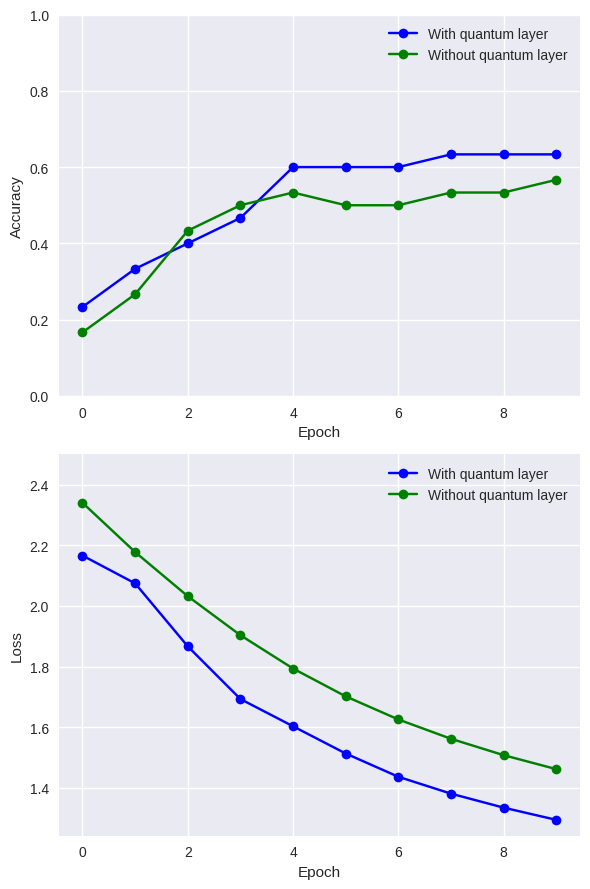

In [13]:
# Plot the results
plt.style.use("seaborn")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

# Plot validation accuracy
ax1.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

# Plot validation loss
ax2.plot(q_history.history["val_loss"], "-ob", label="With quantum layer")
ax2.plot(c_history.history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()

It is possible to examine if the quantum convolution layer offers any advantages in terms of classification accuracy or learning efficiency by contrasting the two models' performances. This method investigates the possibilities of merging conventional and quantum machine learning methods for application in image processing.

**References**
==========

1.  Maxwell Henderson, Samriddhi Shakya, Shashindra Pradhan, Tristan
    Cook. \"Quanvolutional Neural Networks: Powering Image Recognition
    with Quantum Circuits.\"
    [arXiv:1904.04767](https://arxiv.org/abs/1904.04767), 2019.